In [ ]:
# This exercise wasn't exactly smooth sailing for me, but I did try to understand most of it. Will try to come back to this whenever I can

In [ ]:
# there no change change in the first several cells from last lecture

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
# print(len(words))
# print(max(len(w) for w in words))
# print(words[:8])

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
# print(itos)
# print(vocab_size)

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  # print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

In [3]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [4]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [5]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [6]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3596, grad_fn=<NegBackward0>)

Similar boiler plate codes as done in the prev exercise and provided in the starter code^

------------

**EXERCISE 2**

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
# loss_fast = F.cross_entropy(logits, Yb)
# print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

In the above example we are seeing how the forward pass is broken down if we do the manual breakdown of calculation vs just directly using PyTorch

[1:28:34](https://youtu.be/q8SA3rM6ckI?si=O-RCp2YO7QbSbUIW&t=5314) to 1:32:48 - Andrej sensei gives us an hint followed with an explaination of solving the equation and convert that to code

In [7]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

#This wasnt exactly very clear to me, but i will come back to this
#Also my output came slightly bigger than sensei's though

logits          | exact: False | approximate: True  | maxdiff: 8.381903171539307e-09


[1:32:49](https://youtu.be/q8SA3rM6ckI?si=-204uFZWpJPaT9oU&t=5569) to 1:36:36 - Breakdown of what `dlogits` actually is by taking one row and representing it dynamically

In [8]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [9]:
F.softmax(logits, 1)[0]

tensor([0.0727, 0.0823, 0.0164, 0.0532, 0.0213, 0.0895, 0.0218, 0.0357, 0.0174,
        0.0327, 0.0371, 0.0337, 0.0347, 0.0311, 0.0346, 0.0131, 0.0086, 0.0178,
        0.0161, 0.0499, 0.0532, 0.0226, 0.0259, 0.0712, 0.0607, 0.0274, 0.0192],
       grad_fn=<SelectBackward0>)

In [10]:
dlogits[0] * n

tensor([ 0.0727,  0.0823,  0.0164,  0.0532,  0.0213,  0.0895,  0.0218,  0.0357,
        -0.9826,  0.0327,  0.0371,  0.0337,  0.0347,  0.0311,  0.0346,  0.0131,
         0.0086,  0.0178,  0.0161,  0.0499,  0.0532,  0.0226,  0.0259,  0.0712,
         0.0607,  0.0274,  0.0192], grad_fn=<MulBackward0>)

In [11]:
dlogits[0].sum()

tensor(2.0955e-09, grad_fn=<SumBackward0>)

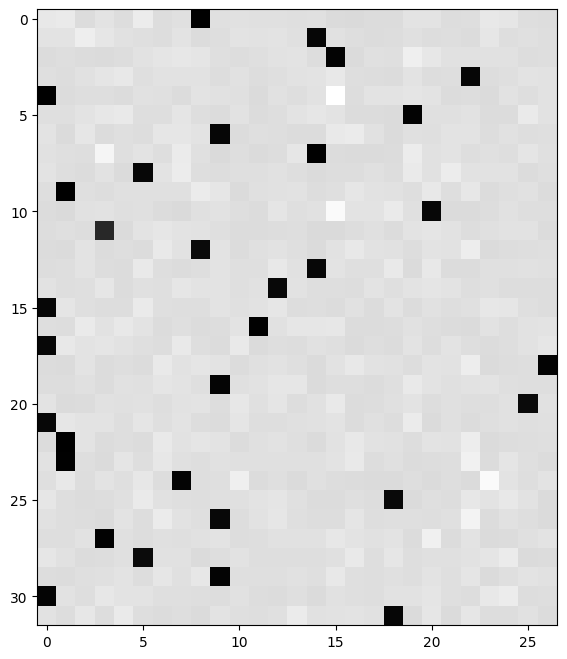

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')